## Assignment: Image recognition
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/4oNHlRFEd71HXp4](https://drive.upm.es/s/4oNHlRFEd71HXp4)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip ""

unzip:  cannot find or open /content/gdrive/MyDrive/xview_recognition.zip, /content/gdrive/MyDrive/xview_recognition.zip.zip or /content/gdrive/MyDrive/xview_recognition.zip.ZIP.


In [ ]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [ ]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [ ]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 45.6 MB/s eta 0:00:00


In [ ]:
import warnings
import rasterio
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, data_augmentation=False, do_shuffle=False):
    if data_augmentation:
        # Define data augmentation parameters
        data_gen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest',
            brightness_range=[0.8, 1.2],
            contrast_stretching=True,
            random_crop=True,
            random_noise=True,
            color_jitter=True
        )

    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i + batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                img = load_geoimage(filename)
                # Apply data augmentation if enabled
                if data_augmentation:
                    img = data_gen.random_transform(img)
                images.append(img)
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            if images:
                images = np.array(images).astype(np.float32)
                labels = np.array(labels).astype(np.float32)
                yield images, labels
            else:
                # Handle case where there are no more images
                break



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [ ]:
import json

# Load database
json_file = 'xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [ ]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [ ]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TerminateOnNaN

# Define the model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())  # Add BatchNormalization layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())  # Add BatchNormalization layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())  # Add BatchNormalization layer
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())  # Add BatchNormalization layer
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 111, 111, 64)      256       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                      

In [ ]:
# Compile the model with a lower learning rate
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Callbacks
model_checkpoint = ModelCheckpoint('model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [ ]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 32
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [ ]:
import math
import numpy as np
print('Training model')
epochs = 30
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/30
602/602 [==============================] - ETA: 0s - loss: 3.3512 - accuracy: 0.3417
Epoch 1: val_accuracy improved from -inf to 0.46399, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 133s 198ms/step - loss: 3.3512 - accuracy: 0.3417 - val_loss: 1.7501 - val_accuracy: 0.4640 - lr: 1.0000e-04
Epoch 2/30
602/602 [==============================] - ETA: 0s - loss: 1.9909 - accuracy: 0.4437
Epoch 2: val_accuracy improved from 0.46399 to 0.55285, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 114s 189ms/step - loss: 1.9909 - accuracy: 0.4437 - val_loss: 1.4279 - val_accuracy: 0.5529 - lr: 1.0000e-04
Epoch 3/30
602/602 [==============================] - ETA: 0s - loss: 1.6340 - accuracy: 0.5008
Epoch 3: val_accuracy improved from 0.55285 to 0.58185, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 108s 180ms/step - loss: 1.6340 - accuracy: 0.5008 - val_loss: 1.4666 - val_accuracy: 0.5819 - lr: 1.0000e-04
Epoch 4/30
602/602 [==============================] - ETA: 0s - loss: 1.4710 - accuracy: 0.5410
Epoch 4: val_accuracy did not improve from 0.58185
602/602 [==============================] - 100s 167ms/step - loss: 1.4710 - accuracy: 0.5410 - val_loss: 1.3068 - val_accuracy: 0.5664 - lr: 1.0000e-04
Epoch 5/30
602/602 [==============================] - ETA: 0s - loss: 1.3493 - accuracy: 0.5653
Epoch 5: val_accuracy improved from 0.58185 to 0.61179, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 120s 200ms/step - loss: 1.3493 - accuracy: 0.5653 - val_loss: 1.2351 - val_accuracy: 0.6118 - lr: 1.0000e-04
Epoch 6/30
602/602 [==============================] - ETA: 0s - loss: 1.2712 - accuracy: 0.5837
Epoch 6: val_accuracy improved from 0.61179 to 0.62675, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 113s 189ms/step - loss: 1.2712 - accuracy: 0.5837 - val_loss: 1.2279 - val_accuracy: 0.6268 - lr: 1.0000e-04
Epoch 7/30
602/602 [==============================] - ETA: 0s - loss: 1.1944 - accuracy: 0.6105
Epoch 7: val_accuracy did not improve from 0.62675
602/602 [==============================] - 106s 177ms/step - loss: 1.1944 - accuracy: 0.6105 - val_loss: 1.1845 - val_accuracy: 0.6193 - lr: 1.0000e-04
Epoch 8/30
602/602 [==============================] - ETA: 0s - loss: 1.0871 - accuracy: 0.6370
Epoch 8: val_accuracy improved from 0.62675 to 0.64172, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 112s 187ms/step - loss: 1.0871 - accuracy: 0.6370 - val_loss: 1.1431 - val_accuracy: 0.6417 - lr: 1.0000e-04
Epoch 9/30
602/602 [==============================] - ETA: 0s - loss: 1.0566 - accuracy: 0.6485
Epoch 9: val_accuracy improved from 0.64172 to 0.65061, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 111s 184ms/step - loss: 1.0566 - accuracy: 0.6485 - val_loss: 1.0815 - val_accuracy: 0.6506 - lr: 1.0000e-04
Epoch 10/30
602/602 [==============================] - ETA: 0s - loss: 0.9844 - accuracy: 0.6729
Epoch 10: val_accuracy improved from 0.65061 to 0.65575, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 107s 178ms/step - loss: 0.9844 - accuracy: 0.6729 - val_loss: 1.1127 - val_accuracy: 0.6558 - lr: 1.0000e-04
Epoch 11/30
602/602 [==============================] - ETA: 0s - loss: 0.9512 - accuracy: 0.6789
Epoch 11: val_accuracy improved from 0.65575 to 0.67212, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 106s 175ms/step - loss: 0.9512 - accuracy: 0.6789 - val_loss: 1.0424 - val_accuracy: 0.6721 - lr: 1.0000e-04
Epoch 12/30
602/602 [==============================] - ETA: 0s - loss: 0.8749 - accuracy: 0.7076
Epoch 12: val_accuracy improved from 0.67212 to 0.67867, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 109s 181ms/step - loss: 0.8749 - accuracy: 0.7076 - val_loss: 1.0501 - val_accuracy: 0.6787 - lr: 1.0000e-04
Epoch 13/30
602/602 [==============================] - ETA: 0s - loss: 0.8161 - accuracy: 0.7251
Epoch 13: val_accuracy did not improve from 0.67867
602/602 [==============================] - 107s 178ms/step - loss: 0.8161 - accuracy: 0.7251 - val_loss: 1.0808 - val_accuracy: 0.6651 - lr: 1.0000e-04
Epoch 14/30
602/602 [==============================] - ETA: 0s - loss: 0.7884 - accuracy: 0.7318
Epoch 14: val_accuracy improved from 0.67867 to 0.69738, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 108s 179ms/step - loss: 0.7884 - accuracy: 0.7318 - val_loss: 0.9985 - val_accuracy: 0.6974 - lr: 1.0000e-04
Epoch 15/30
602/602 [==============================] - ETA: 0s - loss: 0.7276 - accuracy: 0.7532
Epoch 15: val_accuracy did not improve from 0.69738
602/602 [==============================] - 99s 165ms/step - loss: 0.7276 - accuracy: 0.7532 - val_loss: 1.0124 - val_accuracy: 0.6712 - lr: 1.0000e-04
Epoch 16/30
602/602 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.7670
Epoch 16: val_accuracy did not improve from 0.69738
602/602 [==============================] - 107s 177ms/step - loss: 0.6852 - accuracy: 0.7670 - val_loss: 1.0532 - val_accuracy: 0.6651 - lr: 1.0000e-04
Epoch 17/30
602/602 [==============================] - ETA: 0s - loss: 0.6508 - accuracy: 0.7807
Epoch 17: val_accuracy did not improve from 0.69738
602/602 [==============================] - 107s 177ms/step - loss: 0.6508 - accuracy: 0.7807 - val

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 112s 185ms/step - loss: 0.2986 - accuracy: 0.9013 - val_loss: 0.9956 - val_accuracy: 0.7161 - lr: 1.0000e-05
Epoch 26/30
602/602 [==============================] - ETA: 0s - loss: 0.2690 - accuracy: 0.9105
Epoch 26: val_accuracy improved from 0.71609 to 0.72264, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 113s 188ms/step - loss: 0.2690 - accuracy: 0.9105 - val_loss: 0.9868 - val_accuracy: 0.7226 - lr: 1.0000e-05
Epoch 27/30
602/602 [==============================] - ETA: 0s - loss: 0.2420 - accuracy: 0.9161
Epoch 27: val_accuracy improved from 0.72264 to 0.72311, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 113s 188ms/step - loss: 0.2420 - accuracy: 0.9161 - val_loss: 0.9700 - val_accuracy: 0.7231 - lr: 1.0000e-05
Epoch 28/30
602/602 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9267
Epoch 28: val_accuracy improved from 0.72311 to 0.72778, saving model to model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


602/602 [==============================] - 119s 198ms/step - loss: 0.2197 - accuracy: 0.9267 - val_loss: 0.9769 - val_accuracy: 0.7278 - lr: 1.0000e-05
Epoch 29/30
602/602 [==============================] - ETA: 0s - loss: 0.2012 - accuracy: 0.9322
Epoch 29: val_accuracy did not improve from 0.72778
602/602 [==============================] - 106s 177ms/step - loss: 0.2012 - accuracy: 0.9322 - val_loss: 0.9714 - val_accuracy: 0.7245 - lr: 1.0000e-05
Epoch 30/30
602/602 [==============================] - ETA: 0s - loss: 0.1914 - accuracy: 0.9359
Epoch 30: val_accuracy did not improve from 0.72778
602/602 [==============================] - 99s 164ms/step - loss: 0.1914 - accuracy: 0.9359 - val_loss: 0.9982 - val_accuracy: 0.7268 - lr: 1.0000e-05
Best validation model: epoch 28  - val_accuracy 0.7277829647064209


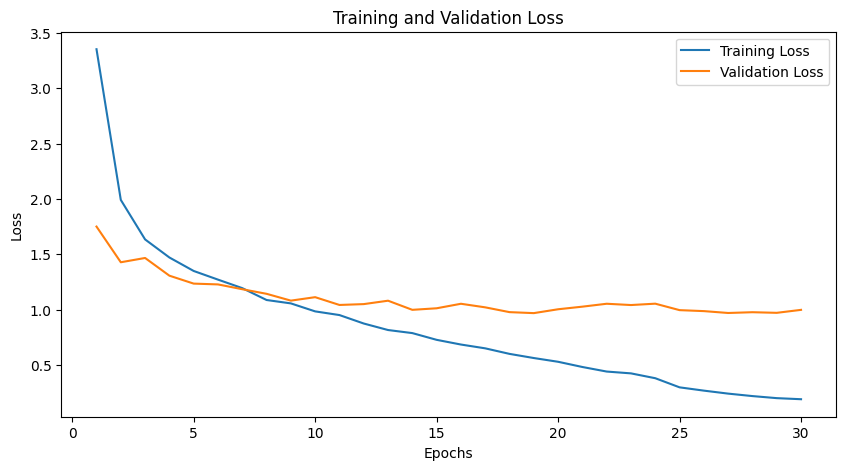

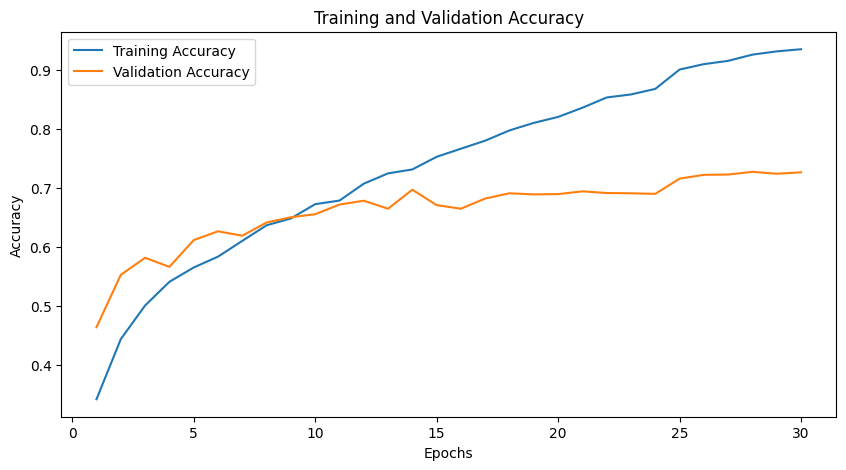

In [ ]:
# Plotting
epochs_range = range(1, epochs + 1)

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, h.history['loss'], label='Training Loss')
plt.plot(epochs_range, h.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, h.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, h.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

#### Testing
Try to improve the results provided in the Moodle competition wiki.

In [ ]:
import json

# Load database
json_file = 'xview_ann_test.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [ ]:
import numpy as np

anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    image.add_object(obj)
    anns.append(image)

In [ ]:
import numpy as np

# model.load_weights('model.hdf5', by_name=True)
y_true, y_pred = [], []
for ann in anns:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

1/1 [==============================] - ETA: 0s

<ipython-input-8-39df9ea0fe34>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


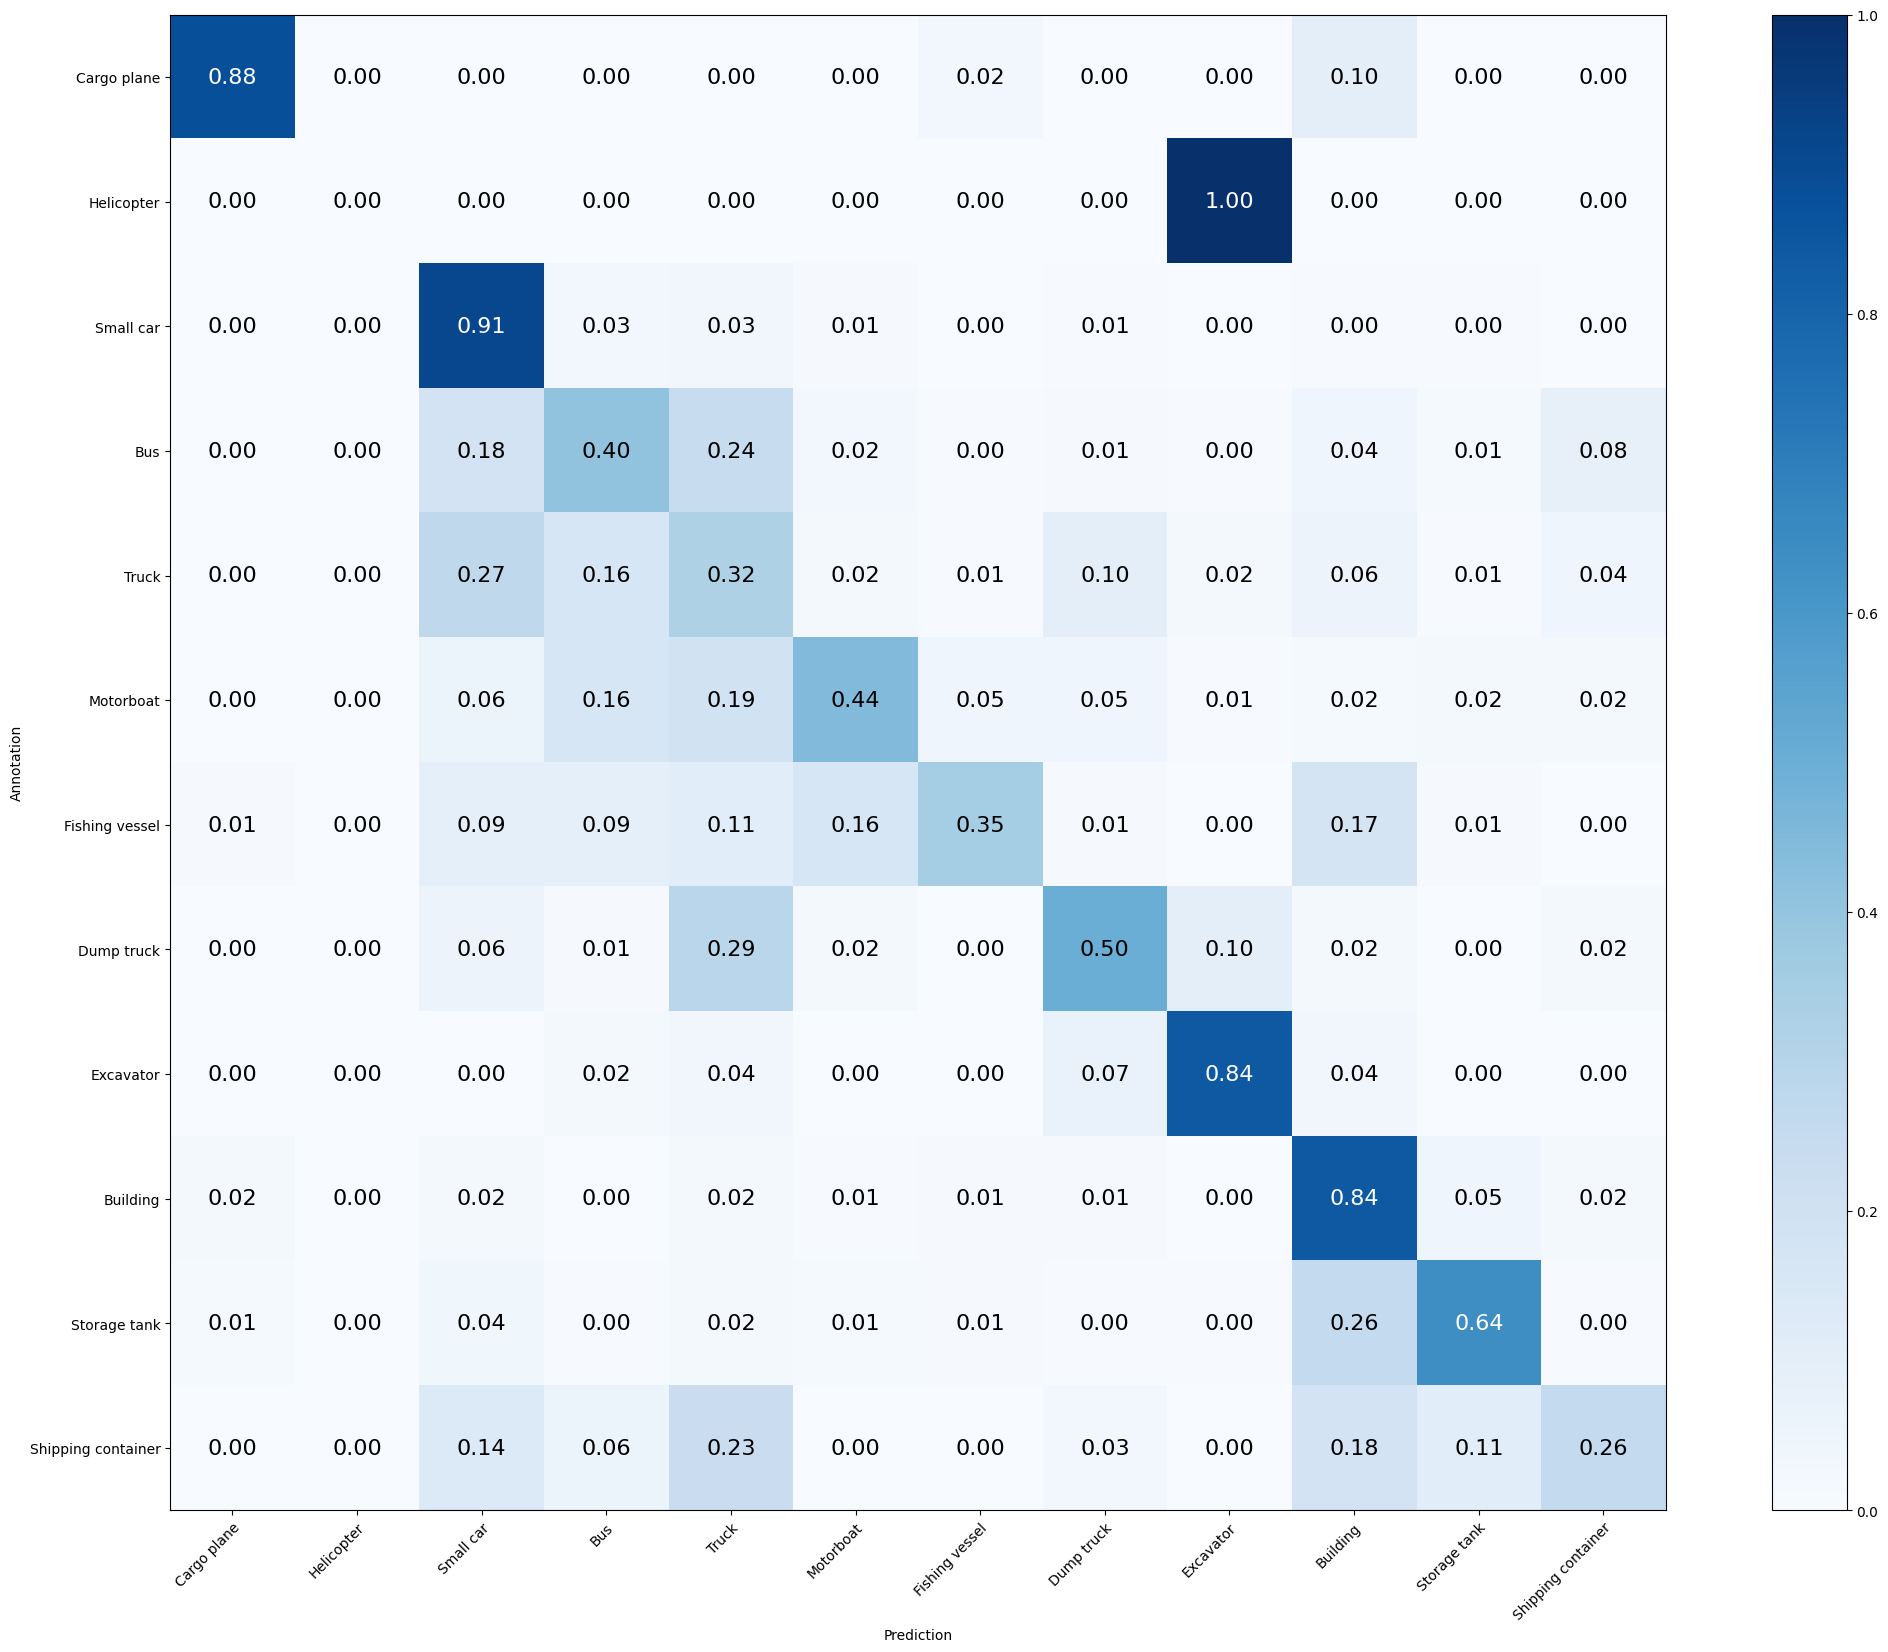

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [ ]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 62.846%
Mean Recall: 53.256%
Mean Precision: 54.037%
> Cargo plane: Recall: 87.952% Precision: 83.908% Specificity: 99.451% Dice: 85.882%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Small car: Recall: 90.965% Precision: 69.436% Specificity: 90.922% Dice: 78.756%
> Bus: Recall: 40.496% Precision: 40.833% Specificity: 94.066% Dice: 40.664%
> Truck: Recall: 32.131% Precision: 30.061% Specificity: 90.215% Dice: 31.062%
> Motorboat: Recall: 44.162% Precision: 81.690% Specificity: 98.260% Dice: 57.331%
> Fishing vessel: Recall: 35.484% Precision: 52.381% Specificity: 98.820% Dice: 42.308%
> Dump truck: Recall: 50.000% Precision: 48.031% Specificity: 97.374% Dice: 48.996%
> Excavator: Recall: 84.211% Precision: 64.865% Specificity: 98.991% Dice: 73.282%
> Building: Recall: 84.133% Precision: 76.897% Specificity: 93.454% Dice: 80.352%
> Storage tank: Recall: 63.786% Precision: 76.733% Specificity: 98.035% Dice: 69.663%
> Shipping container

#### Report

You must prepare a report (PDF) describing:
* The problems and data sets (briefly).
* The process that you have followed to reach your solution for the “xview_recognition” benchmark, including your intermediate results. You must discuss and compare these results properly.
* Final network architectures, including optimization algorithms, regularization methods (dropout, data augmentation, etc.), number of layers/parameters, and performance obtained with your model on the train/valid/test data sets, including the plots of the evolution of losses and accuracy.
* It would also be very valuable your feedback on the use of “Cesvima” or “Google Colab" services.

In the submission via Moodle, attach your Python (.py) or Jupyter Notebook (.ipynb) source file, including in the report all results of computations attached to the code that generated them.

The assignment must be done in groups of 3 students.